In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline 

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.pylab as pl
import matplotlib
import uproot # 4

In [4]:
def deltar(df):
    df['tc_deta'] = df['tc_eta']-df['genpart_exeta']
    df['tc_dphi'] = np.abs(df['tc_phi']-df['genpart_exphi'])
    sel = df['tc_dphi']>np.pi
    df['tc_dphi'] -= sel*(2*np.pi)
    return(np.sqrt(df['tc_dphi']*df['tc_dphi']+df['tc_deta']*df['tc_deta']))

In [7]:
file_name_ele = '../CMSSW_12_5_0_pre4/src/L1Trigger/L1THGCalUtilities/test/ntuple_RelValSingleEFlatPt2To100_2026D88noPU.root'
file_name_pho = '../CMSSW_12_5_0_pre4/src/L1Trigger/L1THGCalUtilities/test/ntuple_RelValSingleGammaFlatPt8To150_2026D88noPU.root'
tree_name = 'hgcalTriggerNtuplizer/HGCalTriggerNtuple'
branches_gen=['event','genpart_pid','genpart_exphi', 'genpart_exeta','genpart_gen',
        'genpart_reachedEE', 'genpart_pt', 'genpart_energy']
branches_cl3d=['event', 'cl3d_pt','cl3d_eta','cl3d_phi']
branches_tc = ['event', 'tc_pt', 'tc_mipPt', 'tc_eta', 'tc_phi', 'tc_layer']
#
etamin = 1.7
etamax = 2.8
ptmin = 0.
mipt_threshold = 0.5
deltar_radius = 0.1

In [27]:
def load_ntuple(file_name):
    print(f'Loading {file_name}')
    tree = uproot.open(file_name)[tree_name]
    df_gen = tree.arrays(branches_gen, library='pd')
    df_cl = tree.arrays(branches_cl3d, library='pd')
    df_tc = tree.arrays(branches_tc, library='pd')
    #
    sel = df_gen['genpart_gen']!=-1
    df_gen = df_gen[sel]
    sel = df_gen['genpart_reachedEE']==2
    df_gen = df_gen[sel]
    #sel = df_gen['genpart_pt']>20
    #df_gen = df_gen[sel]
    sel = np.abs(df_gen['genpart_exeta'])>etamin
    df_gen = df_gen[sel]
    sel = np.abs(df_gen['genpart_exeta'])<etamax
    df_gen = df_gen[sel]
    df_gen_pos = df_gen[df_gen['genpart_exeta']>0]
    df_gen_neg = df_gen[df_gen['genpart_exeta']<0]
    df_gen_pos.set_index('event', inplace=True)
    df_gen_neg.set_index('event', inplace=True)
    #
    df_cl_pos = df_cl[df_cl['cl3d_eta']>0]
    df_cl_neg = df_cl[df_cl['cl3d_eta']<0]
    df_cl_pos.set_index('event', inplace=True)
    df_cl_neg.set_index('event', inplace=True)
    #
    sel = df_tc['tc_layer']<28
    df_tc = df_tc[sel]
    sel = df_tc['tc_mipPt']>mipt_threshold
    df_tc = df_tc[sel]
    df_tc_pos = df_tc[df_tc['tc_eta']>0]
    df_tc_neg = df_tc[df_tc['tc_eta']<0]
    df_tc_pos.set_index('event', inplace=True)
    df_tc_neg.set_index('event', inplace=True)
    #
    #df_pos = df_gen_pos.join(df_cl_pos, how='left', rsuffix='_cl')
    #df_neg = df_gen_neg.join(df_cl_neg, how='left', rsuffix='_cl')
    df_pos = df_gen_pos.join(df_tc_pos, how='left', rsuffix='_tc')
    df_neg = df_gen_neg.join(df_tc_neg, how='left', rsuffix='_tc')
    #
    df_pos['zside'] = 1
    df_neg['zside'] = -1
    df_pos['tc_deltar'] = deltar(df_pos)
    df_neg['tc_deltar'] = deltar(df_neg)
    sel = df_pos.tc_deltar<deltar_radius
    df_pos = df_pos[sel]
    sel = df_neg.tc_deltar<deltar_radius
    df_neg = df_neg[sel]
    df = pd.concat([df_pos, df_neg])
    return df

In [44]:
df_ele = load_ntuple(file_name_ele)
df_pho = load_ntuple(file_name_pho)
df = pd.concat([df_ele, df_pho])
df['genpart_pid'].replace([-11,11],1, inplace=True)
df['genpart_pid'].replace([22],0, inplace=True)
df

Loading ../CMSSW_12_5_0_pre4/src/L1Trigger/L1THGCalUtilities/test/ntuple_RelValSingleEFlatPt2To100_2026D88noPU.root
Loading ../CMSSW_12_5_0_pre4/src/L1Trigger/L1THGCalUtilities/test/ntuple_RelValSingleGammaFlatPt8To150_2026D88noPU.root


,genpart_pid,genpart_exphi,genpart_exeta,genpart_gen,genpart_reachedEE,genpart_pt,genpart_energy,tc_pt,tc_mipPt,tc_eta,tc_phi,tc_layer,zside,tc_deta,tc_dphi,tc_deltar
event,,,,,,,,,,,,,,,,
5,1,-2.392516,2.516547,2,2,34.108475,213.574371,0.040656,1.393841,2.475509,-2.357290,23,1,-0.041038,0.035226,0.054083
5,1,-2.392516,2.516547,2,2,34.108475,213.574371,0.021793,0.747156,2.493161,-2.488088,9,1,-0.023386,0.095572,0.098392
5,1,-2.392516,2.516547,2,2,34.108475,213.574371,0.038324,3.231504,2.495096,-2.376636,1,1,-0.021451,0.015881,0.026690
5,1,-2.392516,2.516547,2,2,34.108475,213.574371,0.024590,2.073441,2.452729,-2.386977,1,1,-0.063818,0.005539,0.064058
5,1,-2.392516,2.516547,2,2,34.108475,213.574371,0.030266,1.037640,2.571177,-2.430912,3,1,0.054630,0.038396,0.066773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,0,2.292450,-1.947770,3,2,104.088615,372.451447,0.015806,0.541875,-1.965526,2.204254,23,-1,-0.017756,0.088196,0.089966
8995,0,2.292450,-1.947770,3,2,104.088615,372.451447,0.029350,1.006209,-1.959487,2.251101,23,-1,-0.011717,0.041349,0.042977
8995,0,2.292450,-1.947770,3,2,104.088615,372.451447,0.089835,3.079878,-1.938568,2.259369,23,-1,0.009202,0.033081,0.034337


In [45]:
df['bin_pt'] = (df.genpart_pt/10.).astype('int32')
columns = ['genpart_pid', 'event', 'zside', 'bin_pt', 'tc_layer', 'tc_pt', 'tc_mipPt']
sum_layers = df.reset_index()[columns]\
.groupby(['genpart_pid','event', 'zside', 'bin_pt', 'tc_layer']).sum().reset_index()
sum_layers

,genpart_pid,event,zside,bin_pt,tc_layer,tc_pt,tc_mipPt
0,0,3,-1,11,1,0.006641,0.560012
1,0,3,-1,11,3,0.559452,19.197868
2,0,3,-1,11,5,3.860401,132.379532
3,0,3,-1,11,7,13.588219,466.388550
4,0,3,-1,11,9,18.134813,623.841980
...,...,...,...,...,...,...,...
91367,1,8999,1,0,15,0.479034,16.423008
91368,1,8999,1,0,17,0.368617,12.637530
91369,1,8999,1,0,21,0.021758,0.745931
91370,1,8999,1,0,25,0.015928,0.546058


In [46]:
def profile(event):
    sum_pt = np.sum(event.tc_pt)
    sum_mipPt = np.sum(event.tc_mipPt)
    event.tc_pt /= sum_pt
    event.tc_mipPt /= sum_mipPt
    return event


In [47]:
longitudinal_profile = sum_layers.groupby(['genpart_pid', 'event', 'zside']).apply(profile).reset_index()
mean_profile = longitudinal_profile.groupby(['genpart_pid', 'bin_pt', 'tc_layer']).mean().reset_index()
longitudinal_profile

,index,genpart_pid,event,zside,bin_pt,tc_layer,tc_pt,tc_mipPt
0,0,0,3,-1,11,1,0.000060,0.000147
1,1,0,3,-1,11,3,0.005076,0.005036
2,2,0,3,-1,11,5,0.035028,0.034723
3,3,0,3,-1,11,7,0.123297,0.122334
4,4,0,3,-1,11,9,0.164551,0.163634
...,...,...,...,...,...,...,...,...
91367,91367,1,8999,1,0,15,0.076535,0.075481
91368,91368,1,8999,1,0,17,0.058893,0.058083
91369,91369,1,8999,1,0,21,0.003476,0.003428
91370,91370,1,8999,1,0,25,0.002545,0.002510


In [52]:
n_pts = 10
colors = pl.cm.jet(np.linspace(0,1,n_pts))
legends = [
   '2-10 GeV', 
   '10-20 GeV', 
   '20-30 GeV', 
   '30-40 GeV', 
   '40-50 GeV', 
   '50-60 GeV', 
   '60-70 GeV', 
   '70-80 GeV', 
   '80-90 GeV', 
   '90-100 GeV', 
]
yaxis_label = {
    'tc_pt':r'$\langle p_{T}$ fraction$\rangle$',
    'tc_mipPt':r'$\langle mip_{T}$ fraction$\rangle$',
}
plot_title = {
    0:"unconverted photons longitudinal profile",
    1:"electrons longitudinal profile",
}

In [53]:
def plot_profiles(pt_variable, particle_type):
    plt.figure(dpi=120)
    for bin_pt in range(n_pts):
        plt.plot(mean_profile.query(f'genpart_pid=={particle_type} & bin_pt=={bin_pt}')\
                 .set_index('tc_layer').tc_pt,
                 'o-',
                 color=colors[bin_pt],
                label=legends[bin_pt])
    plt.xlabel('layer')
    plt.ylabel(yaxis_label[pt_variable])
    plt.grid()
    plt.legend()
    plt.title(plot_title[particle_type])
    plt.show()

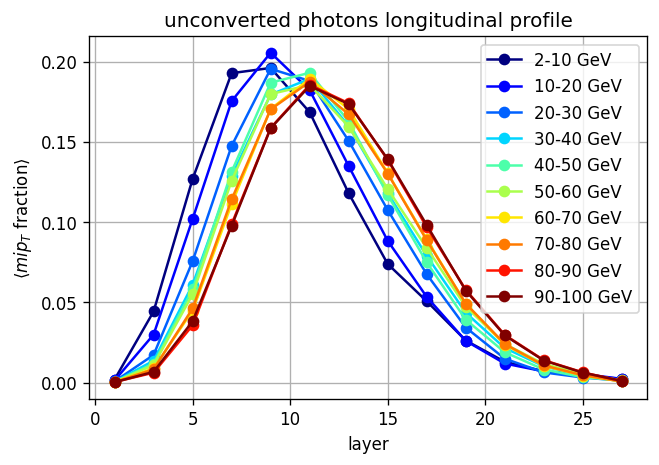

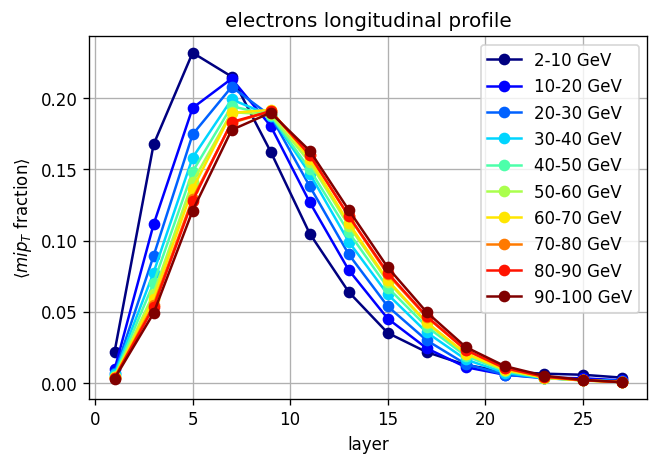

In [55]:
plot_profiles('tc_mipPt', particle_type=0)
plot_profiles('tc_mipPt', particle_type=1)